### Recruitment task for the position of an Trainee Machine Learning Engineer ###
Amazon reviews - data analysis with machine learning and natural language processing elements <br>
Daniel Jankowski <br>
<br>
<br>
Table of contents
1. [Number of selling products depending on the month of the year](#number-of-selling-products-depending-on-the-month-of-the-year)
2. [Which products sell the best and which have the best reviews?: Product Clustering](#which-products-sell-the-best-and-which-have-the-best-reviews-products-clustering)
3. [Review classification](#review-classification) <br>
    3a. [Examination and analysis of selected data](#examination-and-analysis-of-selected-data)

In [1]:
#import neccesary libraries
#library for reading data from file
import gzip
#common libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
#data visualization libraries
import matplotlib.pyplot as plt
#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
#libraries for data vectorization
from sklearn.feature_extraction.text import CountVectorizer
#libraries for data pre-processing and NLP
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Modified code from Web Data: Amazon reviews
def parse(filename):
  f = gzip.open(filename, 'r')
  entry = {}
  for l in f:
    l = l.decode('utf8').strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

#create list with dictionaries, from which we will create dataframe
data = []
for e in parse("data\Cell_Phones_&_Accessories.txt.gz"):
  data.append(e)


In [3]:
#read the data as pandas dataframe
df = pd.DataFrame(data)
#rename columns
df.columns = ['productID','product','price','userID','profile','helpfulness','score','date','summary','text']

#Replace all unknown values with None
df = df.replace({'unknown': None})

#Convert column types
df[['price','score','date']] = df[['price','score','date']].apply(pd.to_numeric)
df['date'] = pd.to_datetime(df['date'], unit='s')
df[['productID','product','userID','profile','helpfulness','summary','text']] = \
    df[['productID','product','userID','profile','helpfulness','summary','text']].astype("string")


### Number of selling products depending on the month of the year ###

In the beginning I decided to conduct a simple and predictable analysis of the number of products sold in each month of the year. As we all probably expect, the sales increases during the Christmas Time, when people usually buy gifts for their family. The only problem, which we actually have to think about is fact that our data consists of customers reviews, not about customer purchases. To simplify, we actually have a date of opinion, not the date of purchase, and as we know, customers can give their feedback a long time after they purchase the product.

<b>Hypothesis: The number of products sold increases during the Christmas Time </b>



In [10]:
#Create copy of original dataframe
df_sales = df.copy()
#Extract the month from the datatime
df_sales['month'] = df_sales['date'].dt.month

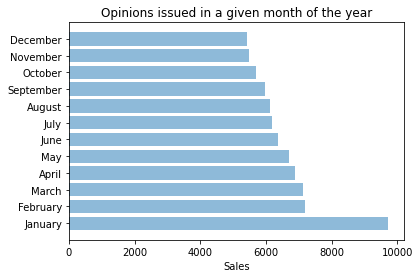

In [23]:
import calendar
#Number of reviews in all months
month_sales = df_sales['month'].value_counts().to_numpy()
months = list(calendar.month_name)[1:]

plt.barh(months, month_sales, align='center', alpha=0.5)
plt.xlabel('Sales')
plt.title('Opinions issued in a given month of the year')

plt.show()


In [ ]:
#TODO: wnioski do tej prostej analizy

### Which products sell the best and which have the best reviews?: Products Clustering ###

In [25]:
df_products = df.copy()

In [27]:
df_products['product'].nunique()
#TODO: clustering produktów w kategorie

7150

### Review classification ###

As a first thing, I decided to build simply review classification. I would like to create the model, which based on text review will clasify the user opinion as <i>positive</i> or <i>negative</i>.

#### Examination and analysis of selected data ####

In [4]:
#I create copy of dataframe to keep the original data intact.
df_copy = df.copy()

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

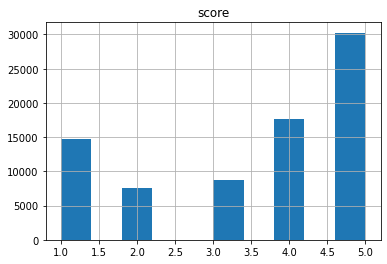

In [7]:
#very intuitive plot of scores distribution of all products
df_copy.hist(column='score')

The data clearly shows that there is the most reviews with score $5.0$, what is quite interesting, but very positive information. In fact, when a customer is satisfied with their purchase, they will not always leave a positive opinion. The other way around, the situation is completely different. Most of customers, who are not satisfied with their purchase, will almost always leave a negative opinion. Therefore based on given data, we can claimed that most of the selling products are of good quality.

There is no such a surprise, that reviews with score $2.0$ and $3.0$ are the least frequent in the data. This is because of the fact, that most of the people treat their purchased product in binary way, i.e. when everything works fine, in most cases customers will rate the product with the highest possible score. The same happens the other way around when the customer is in any way dissatisfied with the purchase, much more often he will give the lowest possible rating.

<b>Therefore based on that observations, I decided to divide all reviews into two groups, such that all reviews with $score >= 4.0$ will be treated as positive opinions and all other will be label as negative one.</b>

In [8]:
#select from dataframe review text and label it based on score
df_copy['label'] = np.where(df_copy['score'] > 3.0, 1, 0)
#from main dataframe we select only text and label column, other columns are not needed for us
reviews = df_copy[['text','label']]
reviews.style.set_properties(subset=['text'], **{'width': '300px'})
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78931 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 925.1 KB


In [9]:
#we have one example, when text attribute is null, therefore we delete it
reviews.dropna(subset=['text'], inplace=True)
reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78930 entries, 0 to 78929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78930 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 1.5 MB


positive examples: 60.78%
negative examples: 39.22%


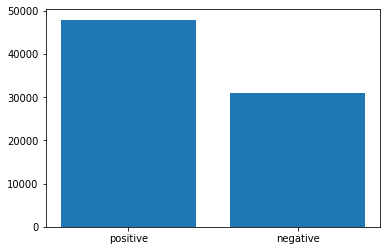

In [10]:
#Count examples of both groups
x = reviews['label'].value_counts()
plt.bar(['positive','negative'], x)
print("positive examples: {:2.2%}".format(x[1]/len(reviews)))
print("negative examples: {:2.2%}".format(x[0]/len(reviews)))

Based on previous observations, there is no thunderbolt that positive opinions are more frequent. Nevertheless, those two groups are quite balanced, therefore there is no need to carry out any data balancing techniques.

#### Pre-processing data ####

Important thing in case of working with text data is to preprocess it. It would make our data more clear and in result the model will be more efficient.

In [11]:
#function, which will clean the data from punctuations, digits and other invalid characters. 
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text.split()

to_remove = stopwords.words('english')

#function which will remove from given review all stopwords, which occurs in english language (words like 'in','he,'where','when' etc.).
def remove_stopword(text):
    return np.setdiff1d(text, to_remove)

#function which will perform lemmatization of words in given review, i.e. convert different forms of one word into one form,
#so they can be analysis as single word 
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    output = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(output)
    

In [12]:
#perform preprocessing
reviews['text'] = reviews['text'].apply(lambda x: lemmatize_text(remove_stopword(preprocess(x))))
reviews.head()


,text,label
0,actually advice another back buy company custo...,0
1,buy cell compared data definite easily easy gr...,1
2,advertised doesnt go good handset hard little ...,1
3,amazon around benefit better big button c cabl...,1
4,buy cable charger data dont usb,0


#### Vectorize data and split it into training and test sets ####



In [13]:
#Create vectorizer, max_features=1500 means that we will take into account only the most 1500 frequent words from our vocabulary
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(reviews['text']).toarray()

In [14]:
#Split our data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, reviews['label'],\
    test_size = 0.2, random_state=12)

#### Building ML model ####

As a first model I would like to try LinearSVC, since its performance in case of text classification is usually very satisficated.

In [16]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(dual=False)
classifier.fit(X_train, y_train)

LinearSVC(dual=False)

In [17]:
#Testing our model
y_predict = classifier.predict(X_test)
y_prob = classifier._predict_proba_lr(X_test)[:,1]

In [22]:
#evaluate the model
print(classification_report(y_test,y_predict)) 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      6190
           1       0.83      0.88      0.85      9596

    accuracy                           0.82     15786
   macro avg       0.81      0.80      0.81     15786
weighted avg       0.82      0.82      0.82     15786

AUC: 0.8890387149734575


|          | Positive | Negative |
|----------|----------|----------|
| Positive | TP=4460  | FP=1730  |
| Negative | FN=1139  | TN=8457  |

$Precision = TP/(TP+FP)$ <br>
$Recall = TP/(TP+FN)$